In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import wandb
import optuna

from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

wandb.require("core")
wandb.login()

wandb: WARNING `wandb.require('core')` is a no-op as it is now the default behavior.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [3]:
# Carga de los datos

ds = pd.read_csv("/global_house_purchase_dataset.csv")
ds.head()

,property_id,country,city,property_type,furnishing_status,property_size_sqft,price,constructed_year,previous_owners,rooms,...,customer_salary,loan_amount,loan_tenure_years,monthly_expenses,down_payment,emi_to_income_ratio,satisfaction_score,neighbourhood_rating,connectivity_score,decision
0,1,France,Marseille,Farmhouse,Semi-Furnished,991,412935,1989,6,6,...,10745,193949,15,6545,218986,0.16,1,5,6,0
1,2,South Africa,Cape Town,Apartment,Semi-Furnished,1244,224538,1990,4,8,...,16970,181465,20,8605,43073,0.08,9,1,2,0
2,3,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,745104,2019,5,2,...,21914,307953,30,2510,437151,0.09,6,8,1,0
3,4,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,1110959,2008,1,3,...,17980,674720,15,8805,436239,0.33,2,6,6,0
4,5,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,99041,2007,6,3,...,17676,65833,25,8965,33208,0.03,3,3,4,0


In [4]:
print("NaN values: \n \n ", ds.isna().sum(),
      "\n \n Types: \n \n", ds.dtypes)

NaN values: 
 
  property_id                0
country                    0
city                       0
property_type              0
furnishing_status          0
property_size_sqft         0
price                      0
constructed_year           0
previous_owners            0
rooms                      0
bathrooms                  0
garage                     0
garden                     0
crime_cases_reported       0
legal_cases_on_property    0
customer_salary            0
loan_amount                0
loan_tenure_years          0
monthly_expenses           0
down_payment               0
emi_to_income_ratio        0
satisfaction_score         0
neighbourhood_rating       0
connectivity_score         0
decision                   0
dtype: int64 
 
 Types: 
 
 property_id                  int64
country                     object
city                        object
property_type               object
furnishing_status           object
property_size_sqft           int64
price               

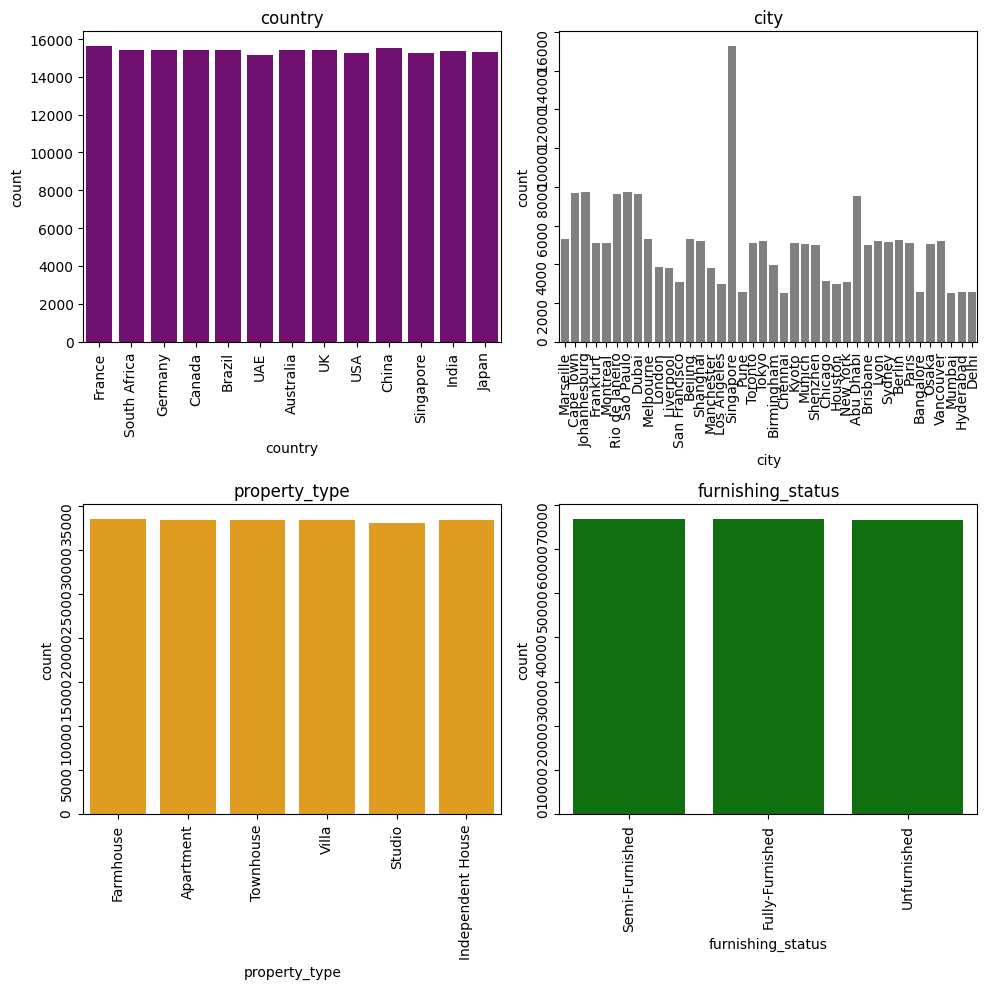

In [5]:
fig, axes = plt.subplots(2, 2, figsize = (10,10))
axes = axes.flatten()

sns.countplot(ds, x = "country", color = "purple", ax = axes[0])
axes[0].tick_params(axis="x", rotation=90)
axes[0].set_title("country")

sns.countplot(ds, x = "city", color = "grey", ax = axes[1])
axes[1].tick_params(rotation = 90)
axes[1].set_title("city")

sns.countplot(ds, x = "property_type", color = "orange", ax = axes[2])
axes[2].tick_params(rotation = 90)
axes[2].set_title("property_type")

sns.countplot(ds, x = "furnishing_status", color = "green", ax = axes[3])
axes[3].tick_params(rotation = 90)
axes[3].set_title("furnishing_status")

plt.tight_layout()
plt.show() 

In [6]:
# One hot encoding
ds = pd.get_dummies(ds, columns = ["country", "city", "property_type", "furnishing_status"],
                            drop_first = True)
ds.drop("property_id", axis = 1, inplace = True)
ds = ds.astype("float32")

ds.head()

,property_size_sqft,price,constructed_year,previous_owners,rooms,bathrooms,garage,garden,crime_cases_reported,legal_cases_on_property,...,city_Tokyo,city_Toronto,city_Vancouver,property_type_Farmhouse,property_type_Independent House,property_type_Studio,property_type_Townhouse,property_type_Villa,furnishing_status_Semi-Furnished,furnishing_status_Unfurnished
0,991.0,412935.0,1989.0,6.0,6.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1244.0,224538.0,1990.0,4.0,8.0,8.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4152.0,745104.0,2019.0,5.0,2.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3714.0,1110959.0,2008.0,1.0,3.0,3.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,531.0,99041.0,2007.0,6.0,3.0,3.0,1.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
print("\n \n Types: \n \n", ds.dtypes)


 
 Types: 
 
 property_size_sqft                  float32
price                               float32
constructed_year                    float32
previous_owners                     float32
rooms                               float32
                                     ...   
property_type_Studio                float32
property_type_Townhouse             float32
property_type_Villa                 float32
furnishing_status_Semi-Furnished    float32
furnishing_status_Unfurnished       float32
Length: 78, dtype: object


In [8]:
x = ds.iloc[:, :-1].values
y = ds.iloc[:, -1].values

print("These are the x values: \n", x,"\n \n These are the y values: \n", y)

These are the x values: 
 [[9.910000e+02 4.129350e+05 1.989000e+03 ... 0.000000e+00 0.000000e+00
  1.000000e+00]
 [1.244000e+03 2.245380e+05 1.990000e+03 ... 0.000000e+00 0.000000e+00
  1.000000e+00]
 [4.152000e+03 7.451040e+05 2.019000e+03 ... 0.000000e+00 0.000000e+00
  1.000000e+00]
 ...
 [3.603000e+03 1.619147e+06 1.990000e+03 ... 0.000000e+00 1.000000e+00
  1.000000e+00]
 [1.706000e+03 3.061650e+05 2.010000e+03 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [3.652000e+03 7.326980e+05 1.986000e+03 ... 0.000000e+00 0.000000e+00
  1.000000e+00]] 
 
 These are the y values: 
 [0. 0. 0. ... 0. 1. 0.]


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.3, random_state = 5)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 1/3, random_state = 5)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 140000
Validation size: 40000
Test size: 20000
